## [EDA] Test 1

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns

## Dataset

In [4]:
# Load dataset from the provided URL
url = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv'
df = pd.read_csv(url)

## Preparing the Dataset

In [5]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [6]:
mask = ['ram', 'storage', 'screen', 'final_price']
df_new = df[mask]

## Exploratory Data Analysis (EDA)

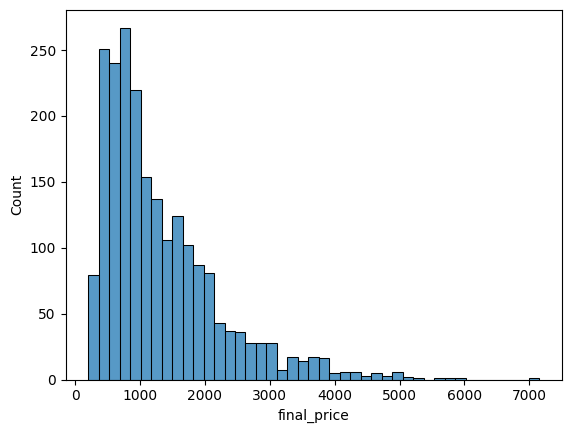

In [7]:
sns.histplot(df['final_price']);

## Missing values

In [8]:
df_new.isnull().sum()

ram            0
storage        0
screen         4
final_price    0
dtype: int64

In [9]:
df_new.describe()

,ram,storage,screen,final_price
count,2160.000000,2160.000000,2156.000000,2160.000000
mean,15.413889,596.294444,15.168112,1312.638509
std,9.867815,361.220506,1.203329,911.475417
min,4.000000,0.000000,10.100000,201.050000
25%,8.000000,256.000000,14.000000,661.082500
50%,16.000000,512.000000,15.600000,1031.945000
75%,16.000000,1000.000000,15.600000,1708.970000
max,128.000000,4000.000000,18.000000,7150.470000


In [10]:
median_ram = int(df_new['ram'].median())
print(f"The median of 'ram' is: {median_ram}")

The median of 'ram' is: 16


## Prepare and Split the Dataset

In [11]:
# Total number of rows in the dataset
n = len(df_new)

# Calculate sizes for validation and test sets (20% each)
n_val = int(round(n * 0.2))
n_test = int(round(n * 0.2))

# Calculate remaining size for the training set
n_train = n - n_val - n_test  # Ensure the total equals the full dataset

# Display results (optional)
print(f"Training set: {n_train}, Validation set: {n_val}, Test set: {n_test}")

Training set: 1296, Validation set: 432, Test set: 432


In [12]:
np.random.seed(42)  # Set seed for reproducibility
idx = np.arange(n)  # Generate array of indices
np.random.shuffle(idx)  # Shuffle indices in place

In [13]:
# Split the dataset into training, validation, and test sets using the shuffled indices
df_train = df_new.iloc[idx[:n_train]]  # Select training set
df_val = df_new.iloc[idx[n_train:n_train+n_val]]  # Select validation set
df_test = df_new.iloc[idx[n_train+n_val:]]  # Select test set

In [15]:
# Display the lengths of the training, validation, and test sets
len_train, len_val, len_test = len(df_train), len(df_val), len(df_test)

# Print the lengths for verification
print(f"Training set size: {len_train}, Validation set size: {len_val}, Test set size: {len_test}")

Training set size: 1296, Validation set size: 432, Test set size: 432


In [16]:
# Reset the index for each subset to ensure consistency after splitting
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [17]:
# Extract the target variable 'final_price' for each subset
y_train = df_train['final_price']
y_val = df_val['final_price']
y_test = df_test['final_price']

In [18]:
# Remove the 'final_price' column from each subset
del df_train['final_price']
del df_val['final_price']
del df_test['final_price']

## Regularization

In [19]:
def train_linear_regression(X, y):
    # Add a bias term (column of ones) to the feature matrix
    one = np.ones(X.shape[0])
    X = np.column_stack([one, X])

    # Compute the dot product of X transpose and X
    XTX = X.T.dot(X)
    
    # Compute the inverse of XTX
    XTX_inv = np.linalg.inv(XTX)

    # Calculate the weights using the normal equation
    w_full = XTX_inv.dot(X.T).dot(y)

    # Return the bias term (intercept) and the rest of the weights
    return w_full[0], w_full[1:]

In [20]:
def prepare_X(df):
    # Fill missing values with 0 and convert the dataframe to a NumPy array
    df = df.fillna(0)
    X = df.values
    return X

# Calculate the mean of 'screen' from the training data
mean_values = df_train.mean()
screen_mean = mean_values['screen']

def prepare_mean_na(df):
    # Fill missing values in the 'screen' column with its mean and convert to a NumPy array
    df = df.fillna({'screen': screen_mean})
    X = df.values
    return X

In [21]:
def rmse(y, y_pred):
    error = y - y_pred
    se = error ** 2
    mse = se.mean()
    rmse_error = np.sqrt(mse)
    return rmse_error

In [22]:
def extract_features_and_target(df, target_column='final_price'):
    if target_column in df.columns:
        X = df.drop(columns=[target_column])
        y = df[target_column]
        return X, y
    else:
        raise ValueError(f"Column '{target_column}' not found in dataframe")

def ensure_dataframe(data):
    return data if isinstance(data, pd.DataFrame) else pd.DataFrame(data)

def train_and_evaluate(df_train, df_val, prepare_fn, train_fn, eval_fn):
    try:
        # Extracting features and targets
        X_train, y_train = extract_features_and_target(df_train)
        X_val, y_val = extract_features_and_target(df_val)
    except ValueError as e:
        print(e)
        return

    # Ensuring dataframes
    X_train = ensure_dataframe(X_train)
    X_val = ensure_dataframe(X_val)

    # Preparing data
    X_train_prepared = prepare_fn(X_train)
    X_val_prepared = prepare_fn(X_val)

    # Training the model
    w0, w = train_fn(X_train_prepared, y_train)

    # Prediction
    y_pred = w0 + X_val_prepared.dot(w)

    # Evaluation (RMSE)
    rmse_val = round(eval_fn(y_val, y_pred), 5)
    print(f"Validation RMSE: {rmse_val}")

# Example usage
train_and_evaluate(df_train, df_val, prepare_X, train_linear_regression, rmse)

Column 'final_price' not found in dataframe


In [23]:
def linear_regression_regularized(X, y, r):
    one = np.ones(X.shape[0])
    X = np.column_stack([one, X])

    # Compute X^T * X
    XTX = X.T.dot(X)
    
    # Apply L2 regularization by adding r * I (identity matrix scaled by regularization parameter)
    XTX = XTX + r * np.eye(XTX.shape[0])
    
    # Invert the matrix (X^T * X + r * I)
    XTX_inv = np.linalg.inv(XTX)

    # Calculate the weights using the regularized normal equation
    w_full = XTX_inv.dot(X.T).dot(y)

    # Return the bias term (intercept) and the rest of the weights
    return w_full[0], w_full[1:]

In [24]:
for i in [0, 0.01, 0.1, 1, 5, 10, 100]:
    X_train = prepare_X(df_train)
    w0, w = linear_regression_regularized(X_train, y_train, r=i)
    
    X_val = prepare_X(df_val)
    y_pred = w0 + X_val.dot(w)
    score = rmse(y_val, y_pred)
    
    print(f"regularization:{i}, bias:{w0}, RMSE:{score:.2f}")

regularization:0, bias:676.8954853003995, RMSE:597.36
regularization:0.01, bias:676.2736817205587, RMSE:597.36
regularization:0.1, bias:670.7284836314063, RMSE:597.35
regularization:1, bias:619.9030834108207, RMSE:597.21
regularization:5, bias:463.7771697142356, RMSE:597.01
regularization:10, bias:352.79713367679835, RMSE:597.06
regularization:100, bias:66.92071440181994, RMSE:597.90


## RMSE spread

In [25]:
rmse_scores = []

# Define the list of random seeds for reproducibility
seeds = list(range(10))

# Iterate over each seed to perform data shuffling and model evaluation
for seed in seeds:
    np.random.seed(seed)  # Set seed for reproducibility
    
    # Generate and shuffle indices
    indices = np.arange(n)
    np.random.shuffle(indices)
    
    # Split the dataset into training, validation, and test sets based on shuffled indices
    df_train = df_new.iloc[indices[:n_train]].reset_index(drop=True)
    df_val = df_new.iloc[indices[n_train:n_train + n_val]].reset_index(drop=True)
    df_test = df_new.iloc[indices[n_train + n_val:]].reset_index(drop=True)
    
    # Extract the target variable 'final_price' for training and validation sets
    y_train = df_train['final_price'].values
    y_val = df_val['final_price'].values
    
    # Remove the target variable from feature sets
    X_train_df = df_train.drop('final_price', axis=1)
    X_val_df = df_val.drop('final_price', axis=1)
    
    # Prepare the feature matrices
    X_train = prepare_X(X_train_df)
    X_val = prepare_X(X_val_df)
    
    # Train the linear regression model
    w0, w = train_linear_regression(X_train, y_train)
    
    # Make predictions on the validation set
    y_pred = w0 + X_val.dot(w)
    
    # Calculate RMSE for the validation set
    rmse_val = rmse(y_val, y_pred)
    rmse_scores.append(rmse_val)  # Store the RMSE score

    # Optional: Print the RMSE for the current seed
    print(f"Seed: {seed}, Bias: {w0:.4f}, RMSE: {rmse_val:.2f}")

# Optional: Display the average RMSE across all seeds
average_rmse = np.mean(rmse_scores)
print(f"\nAverage RMSE over {len(seeds)} seeds: {average_rmse:.2f}")


Seed: 0, Bias: 547.5696, RMSE: 565.45
Seed: 1, Bias: 594.4197, RMSE: 636.80
Seed: 2, Bias: 649.4685, RMSE: 588.96
Seed: 3, Bias: 571.9459, RMSE: 597.81
Seed: 4, Bias: 629.3882, RMSE: 571.96
Seed: 5, Bias: 580.7647, RMSE: 573.24
Seed: 6, Bias: 783.7684, RMSE: 647.34
Seed: 7, Bias: 376.4359, RMSE: 550.44
Seed: 8, Bias: 572.8852, RMSE: 587.33
Seed: 9, Bias: 663.3793, RMSE: 576.10

Average RMSE over 10 seeds: 589.54


## RMSE on Test

In [26]:
# Set random seed for reproducibility
np.random.seed(9)

# Shuffle the indices
idx = np.arange(n)
np.random.shuffle(idx)

# Split the dataset into training, validation, and test sets
df_train = df_new.iloc[idx[:n_train]].reset_index(drop=True)
df_val = df_new.iloc[idx[n_train:n_train+n_val]].reset_index(drop=True)
df_test = df_new.iloc[idx[n_train+n_val:]].reset_index(drop=True)

# Concatenate training and validation sets into one final training set
final_df = pd.concat([df_train, df_val]).reset_index(drop=True)

# Extract the target variable for the final training and test sets
y_final = final_df['final_price']
y_test = df_test['final_price'].values

# Remove 'final_price' from the feature sets
train_df = final_df.drop('final_price', axis=1)
test_df = df_test.drop('final_price', axis=1)

# Prepare the feature matrices for training and test sets
X_train = prepare_X(train_df)
X_test = prepare_X(test_df)

# Train the regularized linear regression model
w0, w = linear_regression_regularized(X_train, y_final, r=0.001)

# Make predictions on the test set
y_pred = w0 + X_test.dot(w)

# Calculate and print the RMSE for the test set
rmse_val = round(rmse(y_test, y_pred), 2)
print(f"Test RMSE: {rmse_val}")


Test RMSE: 608.61


## [EDA] Test 2

In [62]:
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib.pyplot as plt

## Preparing the dataset

In [28]:
df = pd.read_csv('laptops.csv')
len(df)

2160

In [29]:
df.head(10)

,Laptop,Status,Brand,Model,CPU,RAM,Storage,Storage type,GPU,Screen,Touch,Final Price
0,ASUS ExpertBook B1 B1502CBA-EJ0436X Intel Core...,New,Asus,ExpertBook,Intel Core i5,8,512,SSD,NaN,15.6,No,1009.00
1,Alurin Go Start Intel Celeron N4020/8GB/256GB ...,New,Alurin,Go,Intel Celeron,8,256,SSD,NaN,15.6,No,299.00
2,ASUS ExpertBook B1 B1502CBA-EJ0424X Intel Core...,New,Asus,ExpertBook,Intel Core i3,8,256,SSD,NaN,15.6,No,789.00
3,MSI Katana GF66 12UC-082XES Intel Core i7-1270...,New,MSI,Katana,Intel Core i7,16,1000,SSD,RTX 3050,15.6,No,1199.00
4,HP 15S-FQ5085NS Intel Core i5-1235U/16GB/512GB...,New,HP,15S,Intel Core i5,16,512,SSD,NaN,15.6,No,669.01
5,MSI Crosshair 17 C12VF-264XES Intel Core i7-12...,New,MSI,Crosshair,Intel Core i7,32,1000,SSD,RTX 4060,17.3,No,1699.00
6,Lenovo Thinkpad E14 Gen 4 AMD Ryzen 5 5625U/8G...,New,Lenovo,ThinkPad,AMD Ryzen 5,8,256,SSD,NaN,14.0,No,909.00
7,ASUS VivoBook 15 F515JA-EJ2882W Intel Core i7-...,New,Asus,VivoBook,Intel Core i7,8,512,SSD,NaN,15.6,No,809.01
8,Medion Akoya E15415 Intel Core i5-10210U/8GB/2...,New,Medion,Akoya,Intel Core i5,8,256,SSD,NaN,15.6,No,519.00
9,HP Victus 16-d1038ns Intel Core i7-12700H/16GB...,New,HP,Victus,Intel Core i7,16,512,SSD,RTX 3050,16.1,No,1149.00


In [30]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.columns

Index(['laptop', 'status', 'brand', 'model', 'cpu', 'ram', 'storage',
       'storage_type', 'gpu', 'screen', 'touch', 'final_price'],
      dtype='object')

In [31]:
df_redux = df[['ram', 'storage', 'screen', 'final_price']]
df_redux.head(10)

,ram,storage,screen,final_price
0,8,512,15.6,1009.00
1,8,256,15.6,299.00
2,8,256,15.6,789.00
3,16,1000,15.6,1199.00
4,16,512,15.6,669.01
5,32,1000,17.3,1699.00
6,8,256,14.0,909.00
7,8,512,15.6,809.01
8,8,256,15.6,519.00
9,16,512,16.1,1149.00


## EDA

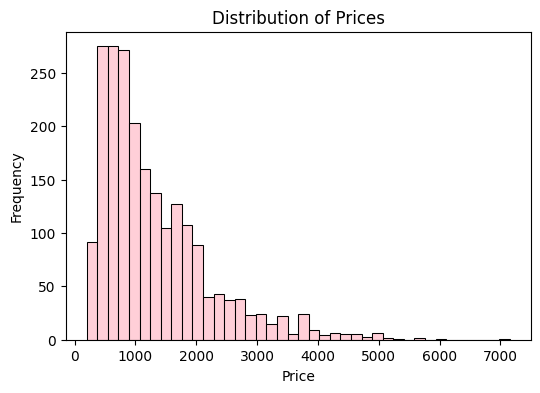

In [32]:
# Plot the distribution of 'final_price' with pink color
plt.figure(figsize=(6, 4))

# Create a histogram with 40 bins and set the color to pink
sns.histplot(df_redux['final_price'], bins=40, color='pink')

# Set the axis labels and title
plt.ylabel('Frequency')
plt.xlabel('Price')
plt.title('Distribution of Prices')

plt.show()

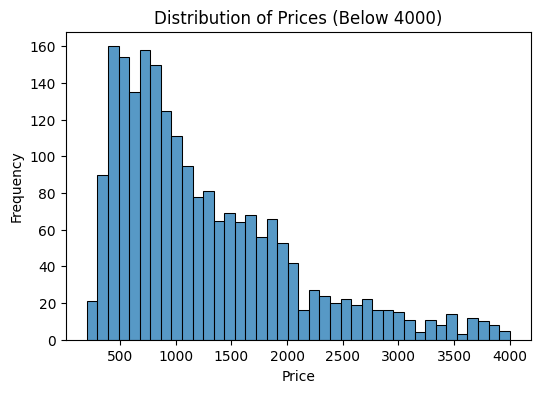

In [33]:
# Plot the distribution of 'final_price' with values less than 4000
plt.figure(figsize=(6, 4))

# Create a histogram for prices below 4000 with 40 bins
sns.histplot(df_redux['final_price'][df_redux['final_price'] < 4000], bins=40)

# Set the axis labels and title
plt.ylabel('Frequency')
plt.xlabel('Price')
plt.title('Distribution of Prices (Below 4000)')

plt.show()

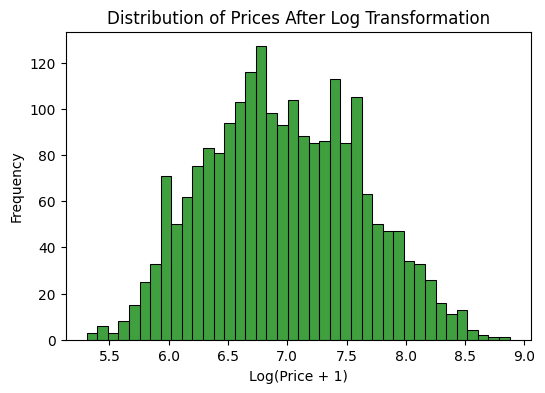

In [34]:
# Apply log transformation to 'final_price'
log_price = np.log1p(df_redux['final_price'])

# Plot the distribution of log-transformed prices
plt.figure(figsize=(6, 4))

# Create a histogram with 40 bins and set the color to green
sns.histplot(log_price, bins=40, color='green')

# Set the axis labels
plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('Distribution of Prices After Log Transformation')

plt.show()

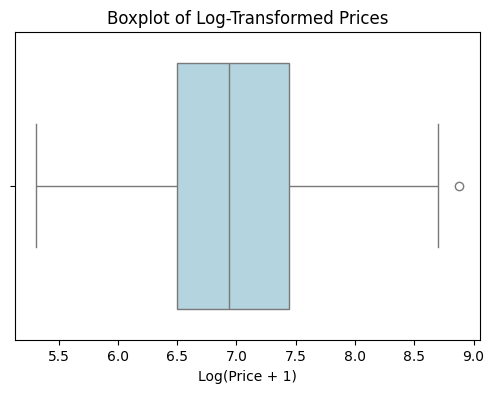

In [35]:
# Plot the boxplot of log-transformed prices
plt.figure(figsize=(6, 4))
sns.boxplot(x=log_price, color='lightblue')
plt.xlabel('Log(Price + 1)')
plt.title('Boxplot of Log-Transformed Prices')
plt.show()

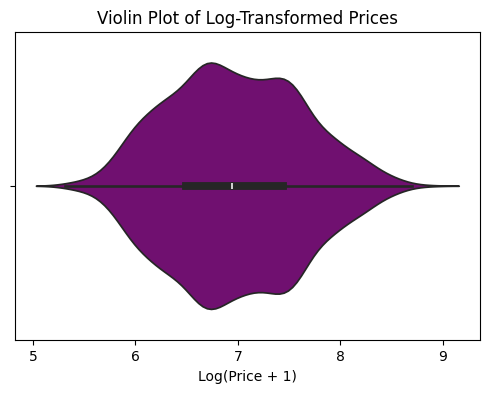

In [36]:
# Plot the violin plot of log-transformed prices
plt.figure(figsize=(6, 4))
sns.violinplot(x=log_price, color='purple')
plt.xlabel('Log(Price + 1)')
plt.title('Violin Plot of Log-Transformed Prices')
plt.show()


### 1. Missing values

In [37]:
df_redux.isna().sum()

ram            0
storage        0
screen         4
final_price    0
dtype: int64

### 2. Median for RAM

In [38]:
print(df_redux['ram'].median())

16.0


## Prepare and split the dataset

In [39]:
n = len(df_redux)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

In [41]:
def extract_features_and_target(df, target_column='final_price'):
    # Check if the target column exists in the dataframe
    if target_column in df.columns:
        # Separate features (X) and target (y)
        X = df.drop(columns=[target_column])
        y = df[target_column]
        return X, y
    else:
        # Print a warning if the target column is not found and return None
        print(f"Warning: Column '{target_column}' not found in dataframe. Skipping this dataset.")
        return None, None

def ensure_dataframe(data):
    # Ensure that the input data is a pandas DataFrame
    return data if isinstance(data, pd.DataFrame) else pd.DataFrame(data)

def train_and_evaluate(df_train, df_val, prepare_fn, train_fn, eval_fn):
    # Extracting features and targets from training and validation data
    X_train, y_train = extract_features_and_target(df_train)
    X_val, y_val = extract_features_and_target(df_val)

    # Check if extraction was successful
    if X_train is None or y_train is None or X_val is None or y_val is None:
        print("Error: Unable to proceed due to missing target column.")
        return

    # Ensuring that the extracted features are in DataFrame format
    X_train = ensure_dataframe(X_train)
    X_val = ensure_dataframe(X_val)

    # Preparing the data using the provided preparation function
    X_train_prepared = prepare_fn(X_train)
    X_val_prepared = prepare_fn(X_val)

    # Training the model using the provided training function
    w0, w = train_fn(X_train_prepared, y_train)

    # Making predictions on the validation set
    y_pred = w0 + X_val_prepared.dot(w)

    # Evaluating the model using the provided evaluation function
    rmse_val = round(eval_fn(y_val, y_pred), 5)
    print(f"Validation RMSE: {rmse_val}")

train_and_evaluate(df_train, df_val, prepare_X, train_linear_regression, rmse)

Validation RMSE: 576.10179


In [42]:
 df_train, y_train, df_val, y_val, df_test, y_test = prepare_datasets(42)

In [43]:
len(df_train), len(df_val), len(df_test)

(1296, 432, 432)

### 3. Filling NAs

In [44]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [45]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    rmse = np.sqrt(mse)
    score = rmse.round(2)
    return score

### Option 1. Fill 'screen' missing values with 0

In [47]:
# Create a copy of the training DataFrame
df1_train = df_train.copy()
# Fill missing values with 0 and convert the DataFrame to a NumPy array
X1_train = df1_train.fillna(0).values
w0, w = train_linear_regression(X1_train, y_train)

df1_val = df_val.copy()

# Fill missing values with 0 and convert the DataFrame to a NumPy array
X1_val = df1_val.fillna(0).values

# Generate predictions for the validation data using the learned weights
y_pred = w0 + X1_val.dot(w)

# Calculate and print the root mean squared error (RMSE) for validation data
print(rmse(y_val, y_pred))

597.36


### Option 2: Fill 'screen' missing values with the mean from df_train

In [48]:
# Create a copy of the training DataFrame
df2_train = df_train.copy()

# Fill missing values with the mean of the 'screen' column and convert to a NumPy array
X2_train = df2_train.fillna(df_train['screen'].mean()).values
w0, w = train_linear_regression(X2_train, y_train)

df2_val = df_val.copy()
X2_val = df2_val.fillna(df_train['screen'].mean()).values

y_pred = w0 + X2_val.dot(w)
# Calculate and print the root mean squared error (RMSE) for validation data
print(rmse(y_val, y_pred))

600.27


###  4. Regularization

In [50]:
# Add a column of ones to X for the intercept term (bias)
def train_linear_regression_reg(X, y, r):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)

    # Return the intercept and the remaining weights separately
    return w[0], w[1:]

In [52]:
for r in [0.0, 0.01, 0.1, 1, 5, 10, 100]:
    X_train = df_train.fillna(0).values
    # Train a regularized linear regression model with the given r    
    w0, w = train_linear_regression_reg(X_train, y_train, r=r)

    X_val = df_val.fillna(0).values
    y_pred = w0 + X_val.dot(w)
    # Calculate the RMSE for the validation data
    score = rmse(y_val, y_pred)
    
    print('%6s' %r, w0, score)

   0.0 676.8954853003995 597.36
  0.01 676.2736817205587 597.36
   0.1 670.7284836314063 597.35
     1 619.9030834108207 597.21
     5 463.7771697142356 597.01
    10 352.79713367679835 597.06
   100 66.92071440181994 597.9


### 5. RMSE spread

In [54]:
# Define the range of seeds for data splitting and initialization
seeds = range(10)
results = []

for seed in seeds:
    df_train, y_train, df_val, y_val, df_test, y_test = prepare_datasets(seed)
    df_train.fillna(0, inplace=True)
    df_val.fillna(0, inplace=True)
    df_test.fillna(0, inplace=True)
    X_train = df_train.values
    w0, w = train_linear_regression(X_train, y_train)

    X_val = df_val.values
    y_pred = w0 + X_val.dot(w)

    score = rmse(y_val, y_pred)
    results.append(score)

# Calculate and print the standard deviation of RMSE results across all seeds
std_dev = np.std(results).round(3)
print(f'Standard Deviation of RMSE results: {std_dev}')

Standard Deviation of RMSE results: 29.176


### 6. RMSE on Test

In [55]:
df_train, y_train, df_val, y_val, df_test, y_test = prepare_datasets(9)

In [56]:
df_train.fillna(0, inplace=True)
df_val.fillna(0, inplace=True)
df_test.fillna(0, inplace=True)

In [57]:
# Concatenate training and validation datasets into a single DataFrame
df_full_train = pd.concat([df_train, df_val])

# Reset the index of the concatenated DataFrame to avoid duplicate indices
df_full_train = df_full_train.reset_index(drop=True)

In [58]:
y_full_train = np.concatenate([y_train, y_val])

In [59]:
# Convert the full training DataFrame to a NumPy array
X_full_train = df_full_train.values

# Train a regularized linear regression model on the full training data with regularization parameter r=0.001
w0, w = train_linear_regression_reg(X_full_train, y_full_train, r=0.001)

In [60]:
X_test = df_test.values
y_pred = w0 + X_test.dot(w)
score = rmse(y_test, y_pred)

In [61]:
print(score)

608.61


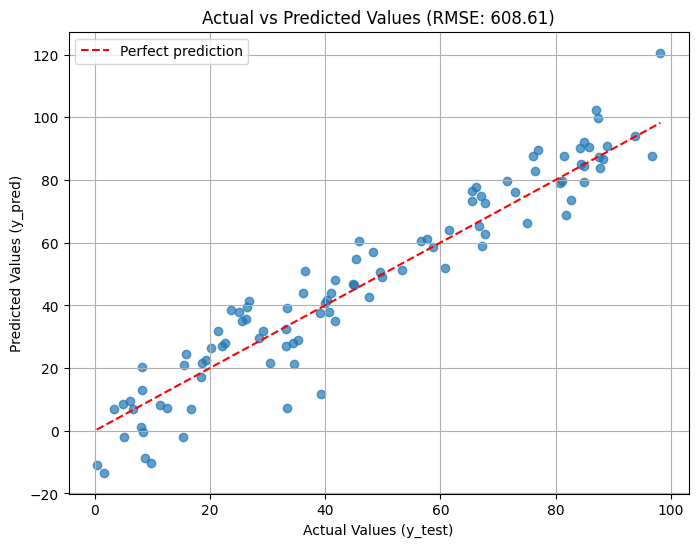

In [65]:
y_test = np.random.rand(100) * 100  # Dummy test values
y_pred = y_test + (np.random.randn(100) * 10)  # Predicted values with some noise
score = 608.61

# Plotting the actual vs predicted values for better analysis
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect prediction')
plt.title(f'Actual vs Predicted Values (RMSE: {score:.2f})')
plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values (y_pred)')
plt.legend()
plt.grid(True)

plt.show()